In [1]:
import numpy as np
import cv2
import math
import collections
import os
from pathlib import Path
from skimage.morphology import skeletonize

In [2]:
import matplotlib.pyplot as plt

def plot_image(img, zoom=1.5):
    assert(2 <= len(img.shape) <= 3)
    
    is_gray = len(img.shape) == 2
    if not is_gray:
        img = img[:,:,::-1]
    n_len = 6.5
    
    n, m = img.shape[:2]
    frac = n / float(m)
    n, m = zoom * frac * n_len, zoom * n_len
    
    fig = plt.figure(figsize=(n, m))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray' if is_gray else None)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.show()

In [3]:
def scale_image_pixels(img):
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min()) * 255
    return img.astype(np.uint8)

# Обработка и распознавание изображений
## Отчет по лабораторной работе №2
### 1.	Постановка задачи

Разработать и реализовать программу для классификации изображений моделей графов, построенных из магнитной головоломки, обеспечивающую:
• Ввод и отображение на экране изображений в формате JPEG;<br>
• Сегментацию изображений на основе точечных и пространственных преобразований;<br>
• Генерацию признаковых описаний структуры графов на изображениях;<br>
• Построение классификатора изображения в соответствии с заданным набором эталонов.<br>
Была выбрана задача класса Intermediate: разработать алгоритм, который сможет классифицировать тестовые картинки по всем 4 типам графа для изображений на белом фоне.

### 2.	Описание данных
В качестве исходных данных прилагается набор из 8 цветных изображений моделей, построенных из деталей магнитной игры-головоломки в формате 1024×768 с разрешением 72 dpi. Всего задано 4 структуры графа, эталоны которых представлены на изображениях 2.jpg (класс I), 3.jpg (класс II), 4.jpg (класс III), 5.jpg (класс IV). На остальных изображениях
представлены графы, изоморфные четырём эталонным образцам (13.jpg (класс I), 25.jpg (класс II), 19.jpg (класс III), 7.jpg (класс IV).
<br>
### 3.	Описания метода решения, программной реализации и проведенных экспериментов для осуществления реализации программы
**1) Построение скелета графа** <br>
Для начала необходимо выполнить обратную бинаризацию изображения. Порог бинаризации 80 подбирался эмпиричесеки. Затем необходимо сгладить границу бинарного изображения и заполнение "дырок" в получившейся маске. Это делается с помощью дилатации кистью диаметра 9. После описанных выше преобразований строится скелет получившегося бинарного изображения. Построение кисти реализовано функцией create_brush(d). <br>

In [4]:
def create_brush(d):
    brush = np.zeros((d, d), dtype=np.uint8)
    cv2.circle(brush, (d // 2, d // 2), d // 2, 1, -1)
    return brush

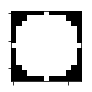

In [5]:
plot_image(create_brush(13),zoom=0.2)

дилатация бинарного изображения:


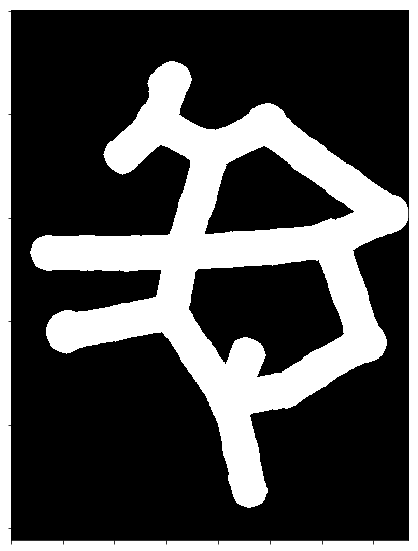

скелет бинарного изображения:


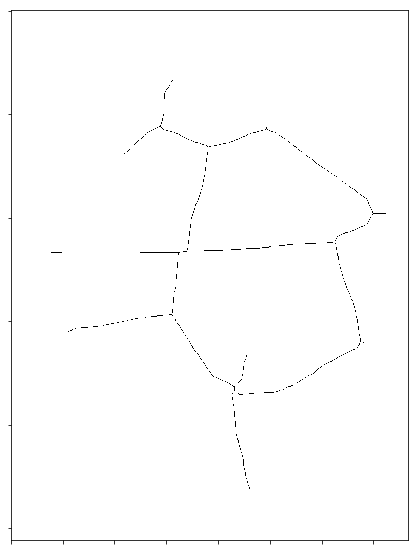

In [6]:
filename="5.jpg"
img = cv2.imread(filename, 0)
_, img_mask = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY_INV)#обратная бинаризация
img = cv2.dilate(img_mask, kernel=create_brush(17), iterations=3)#дилатация
print("дилатация бинарного изображения:")
plot_image(img)
skeleton = skeletonize(img > 0)#построение скелета
skeleton_raw = skeleton.copy()
skeleton=skeleton.astype(np.uint8)*255
skeleton=cv2.bitwise_not(skeleton)
print("скелет бинарного изображения:")
plot_image(skeleton)

**2) Поиск вершин графа** <br>
Поиск вершин в графе выполнялся объединением двух способов. <br>
***2a) Поиск концевых точек скелета*** 
Такой способ реализуется с помощью функции skeleton_endpoints(), которая размывает подаваемое а вход изображение скелета путем свертывания  ядром. 


In [7]:
skel = skeleton_raw.copy()
skel[skel > 0] = 1
skel = skel.astype(np.uint8)
kernel = np.array(
    [[1,  1, 1],
     [1, 10, 1],
     [1,  1, 1]], dtype=np.uint8)
filtered = cv2.filter2D(skel, -1, kernel)

С такой сверткой значение на концах будет равно 11, а в остальных точках 12 или больше, потому что будет 2 или больше соседей. Для точек, не принадлежащих скелету - меньше 10.
Возможны только такие ситуации для концевых точек скелета:

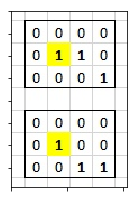

In [8]:
img = cv2.imread("o1.jpg", 1)
plot_image(img,zoom=0.5)


И не возможны такие:

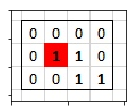

In [9]:
img = cv2.imread("o2.jpg", 1)
plot_image(img,zoom=0.4)

In [10]:
def skeleton_endpoints(skeleton, neighbours=1):
    skeleton = skeleton.copy()
    skeleton[skeleton > 0] = 1
    skeleton = skeleton.astype(np.uint8)

    kernel = np.array(
        [[1,  1, 1],
         [1, 10, 1],
         [1,  1, 1]], dtype=np.uint8)
    filtered = cv2.filter2D(skeleton, -1, kernel)
     #С такой сверткой значение на концах будет равно 11, а в остальных точках 12 или больше, 
     #потому что будет 2 или больше соседей. Для точек, не принадлежащих скелету - меньше 10

    result = np.zeros(skeleton.shape)
    result[np.where(filtered == 10 + neighbours)] = 1 #Значения тех точек, которые интерпретируются как концевые, 
    return result, filtered                                     #приравниваются к 1


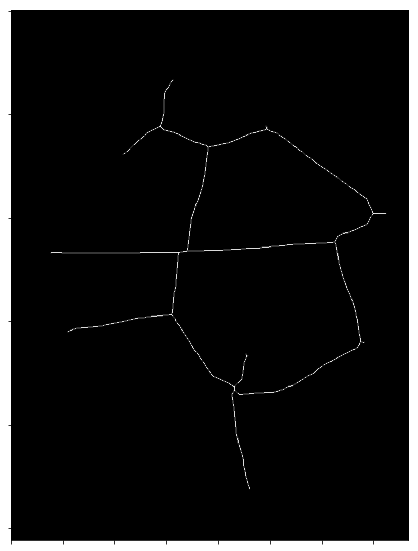

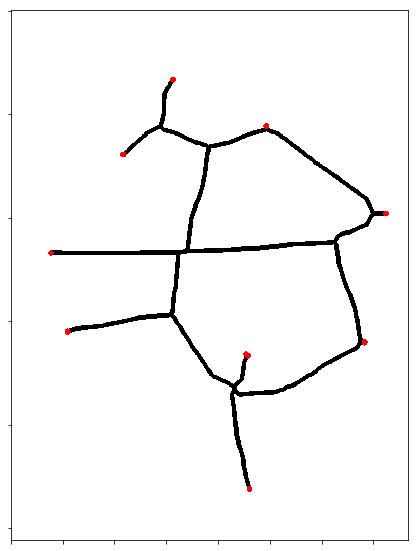

In [12]:
from skimage.color import gray2rgb
result, filtered=skeleton_endpoints(skeleton_raw)
plot_image(filtered)
points =np.where(result!=0)
skel_pix=skeleton_raw.copy()
skel_pix = scale_image_pixels(skel_pix)
skel_pix = cv2.dilate(skel_pix, create_brush(9))
skel_pix = scale_image_pixels(skel_pix)
skel_pix=cv2.bitwise_not(skel_pix)
img_color = gray2rgb(skel_pix)

img_tmp = scale_image_pixels(result)
img_tmp = cv2.dilate(img_tmp, create_brush(7), iterations=2)

img_color[np.where(img_tmp > 0)] = (0, 0, 255)


plot_image(img_color)

***2b) Определение расположения магнитных шариков (нетерминальных вершин графа)*** <br>
Предыдущий способ подходил для нахождения "внешних" графа. Для поиска "внутренних" определялись расположения магнитных шариков.
Для нахождения кругов на изображении в оттенках серого использовалось преобразование Хафа. Минимальный и максимальный радиусы подбирались, ориентируясь на размеры шариков.

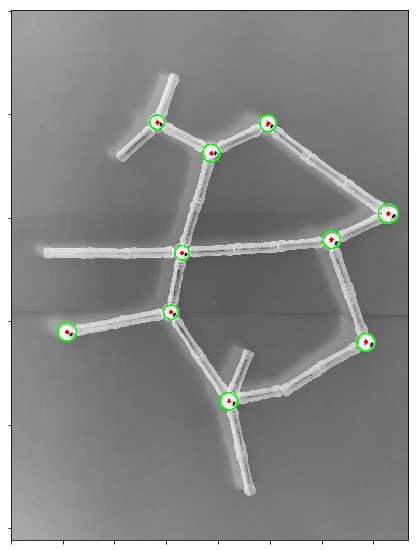

In [13]:
img_gray = cv2.imread(filename, 0)
img=cv2.bitwise_not(img_gray)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,param1=100,param2=22,minRadius=7,maxRadius=20)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # нарисовать окружности
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # нарисовать центры окружностей
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plot_image(cimg)

Далее объединялись выше примененные два способа посика вершин, повторяющиеся вершины были убраны. Если евклидово расстояние между двумя вершинами было меньше 20, то такие вершины рассматривались как одни и те же. 

**2) Определение степени вершин** <br>
Для определения степени вершины рисовалась окружность радиуса 55 с центром в данной вершине и считалось количество пересечений окружности со скелетом.

In [16]:
img= cv2.imread("5.jpg", 0)
skeleton, skel, points = skeleton_ex_points(img,rad=55)

IndexError: tuple index out of range

In [15]:
def skeleton_ex_points(img,rad=55):
    end_points=[]
    _, img_mask = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY_INV)
    img = cv2.dilate(img_mask, kernel=create_brush(13), iterations=3)
    img = cv2.erode(img, kernel=create_brush(1), iterations=1)
    skeleton = skeletonize(img > 0)
    points = skeleton_endpoints(skeleton)
    points =np.where(points!=0)
    
    skel_pix=skeleton.copy()
    skel_pix = scale_image_pixels(skel_pix)
    skel_pix = cv2.dilate(skel_pix, create_brush(9))
    skel_pix = scale_image_pixels(skel_pix)
    skel_pix=cv2.bitwise_not(skel_pix)
    
    skeleton=skeleton.astype(np.uint8)*255
    skeleton=cv2.bitwise_not(skeleton)    

    for i in range(len(points[0])):
        white=np.ones(skel_pix.shape).astype(np.uint8)*255
        cv2.circle(white, (points[1][i], points[0][i]), rad, (0, 0 , 0), 2)    
        cnt_l=cv2.findContours(white, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0][0]
        cnt_r=cv2.findContours(white, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0][1]
        area_r=cv2.contourArea(cnt_r)
        area_l=cv2.contourArea(cnt_l)
        if area_r>area_l:
            if area_l/(math.pi*rad*rad)>0.6:
                end_points.append(np.array([points[1][i], points[0][i]]))
        else:
            end_points.append(np.array([points[1][i], points[0][i]])) 
    return skeleton, skel_pix, end_points